In [1]:
import opendatasets as od
url = "https://www.kaggle.com/splcher/animefacedataset"
od.download(url)

100%|██████████| 395M/395M [00:43<00:00, 9.43MB/s] 


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms


In [12]:
train_data = ImageFolder('C:/Users/Ramesh Babu/.vscode/ECG_analysis/animefacedataset', transform=transforms.Compose([
                                                            transforms.Resize(64),
                                                            transforms.CenterCrop(64),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                        ]))
train_dataLoader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [13]:
test_img = next(iter(train_dataLoader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32])


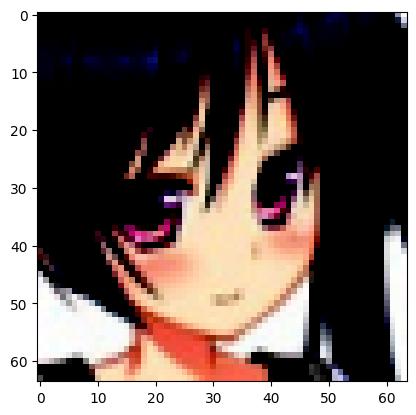

In [14]:
img1, img2 = test_img
print(img2.shape)
img1_test = img1[0].permute(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(img1_test)

In [3]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataLoader = DeviceDataLoader(train_dataLoader, device)
device

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convL1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.convL2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.convL3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.convL4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.convL5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0, bias=False)
        )
        self.Layers = nn.Sequential(
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.Layers(self.convL5(self.convL4(self.convL3(self.convL2(self.convL1(x))))))
    
discriminator = Discriminator()
discriminator = to_device(discriminator, device)
discriminator

Discriminator(
  (convL1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convL2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convL3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convL4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.deConv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.deConv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.deConv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.deConv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.deConv5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.deConv5(self.deConv4(self.deConv3(self.deConv2(self.deConv1(x)))))
    
generator = Generator()
generator = to_device(generator, device)
generator

Generator(
  (deConv1): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deConv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deConv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deConv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (deConv5): Sequential(
  

In [48]:
from torchinfo import summary
summary(model=generator, input_size=(32, 128, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 64, 64]           --
├─Sequential: 1-1                        [32, 512, 4, 4]           --
│    └─ConvTranspose2d: 2-1              [32, 512, 4, 4]           1,048,576
│    └─BatchNorm2d: 2-2                  [32, 512, 4, 4]           1,024
│    └─ReLU: 2-3                         [32, 512, 4, 4]           --
├─Sequential: 1-2                        [32, 256, 8, 8]           --
│    └─ConvTranspose2d: 2-4              [32, 256, 8, 8]           2,097,152
│    └─BatchNorm2d: 2-5                  [32, 256, 8, 8]           512
│    └─ReLU: 2-6                         [32, 256, 8, 8]           --
├─Sequential: 1-3                        [32, 128, 16, 16]         --
│    └─ConvTranspose2d: 2-7              [32, 128, 16, 16]         524,288
│    └─BatchNorm2d: 2-8                  [32, 128, 16, 16]         256
│    └─ReLU: 2-9                         [32, 128, 16, 16]   

In [49]:
from torchinfo import summary
summary(model=discriminator, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          3,072
│    └─BatchNorm2d: 2-2                  [32, 64, 32, 32]          128
│    └─LeakyReLU: 2-3                    [32, 64, 32, 32]          --
├─Sequential: 1-2                        [32, 128, 16, 16]         --
│    └─Conv2d: 2-4                       [32, 128, 16, 16]         131,072
│    └─BatchNorm2d: 2-5                  [32, 128, 16, 16]         256
│    └─LeakyReLU: 2-6                    [32, 128, 16, 16]         --
├─Sequential: 1-3                        [32, 256, 8, 8]           --
│    └─Conv2d: 2-7                       [32, 256, 8, 8]           524,288
│    └─BatchNorm2d: 2-8                  [32, 256, 8, 8]           512
│    └─LeakyReLU: 2-9                    [32, 256, 8, 8]           --

In [7]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    images = images.cpu()
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dataLoader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


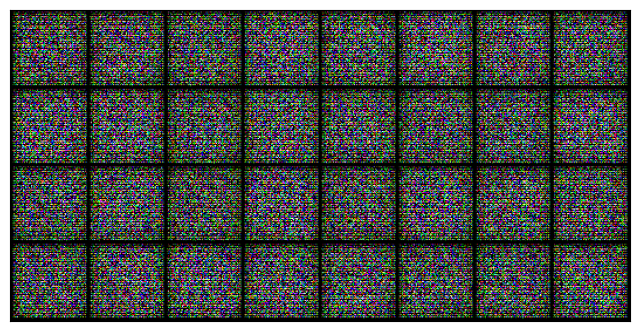

In [53]:
random_input_generator = torch.randn(32, 128, 1, 1)
random_input_generator = to_device(random_input_generator, device)
fake_images = generator(random_input_generator)
show_images(fake_images)

In [100]:
def train_discriminator(real_images, optim_d):
    optim_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), device=device).unsqueeze(dim=1)
    real_loss = torch.nn.BCELoss()(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    fake_vals = torch.randn(32, 128, 1, 1)
    fake_vals = to_device(fake_vals,device)
    fake_images = generator(fake_vals)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), device=device).unsqueeze(dim=1)
    fake_loss = torch.nn.BCELoss()(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss+fake_loss
    loss.backward()
    optim_d.step()

    return loss.item(), real_score, fake_score

In [116]:
def train_generator(optim_g):
    optim_g.zero_grad()

    vals = torch.randn(32, 128, 1, 1)
    vals = to_device(vals, device)
    images = generator(vals)

    preds = discriminator(images)
    targets = torch.ones(images.size(0), device=device).unsqueeze(dim=1)
    loss = torch.nn.BCELoss()(preds, targets)
    
    loss.backward()
    optim_g.step()

    return loss.item()

In [121]:
from torchvision.utils import save_image
import os

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    latent_tensors = to_device(latent_tensors, device)
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [147]:
fixed_fake_images = torch.randn(32, 128, 1, 1)

In [125]:
def fit(epochs, lr, start_idx=5):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optim_d = torch.optim.Adam(params=discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    optim_g = torch.optim.Adam(params=generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        start_idx +=1
        for real_images, _ in train_dataLoader:

            loss_d, real_score, fake_score = train_discriminator(real_images, optim_d)
            loss_g = train_generator(optim_g)

            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

            save_samples(start_idx, fixed_fake_images, show=False)
            
    return losses_g, losses_d, real_scores, fake_scores

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


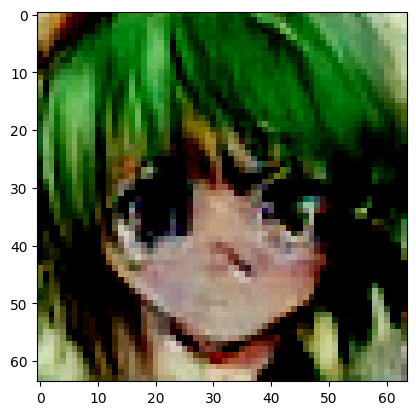

In [148]:
x = fixed_fake_images
x = to_device(x, device)
x = generator(x)
x = x.permute(0,2,3,1)
x = to_device(x[0], 'cpu')
plt.imshow(x.detach().numpy())

In [136]:
from pathlib import Path

model_path = Path('models')
model_name = "generator_state_dict.pt"
model_save_path = model_path/model_name
print("Saving done")
torch.save(generator.state_dict(), model_save_path)

model_path = Path('models')
model_name = "discriminator_state_dict.pt"
model_save_path = model_path/model_name
print("Saving done")
torch.save(discriminator.state_dict(), model_save_path)

Saving done
Saving done


In [9]:
from pathlib import Path
loaded_gen = Generator()
model_path = Path('models')
model_name = "generator_state_dict.pt"
model_save_path = model_path/model_name
loaded_gen.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


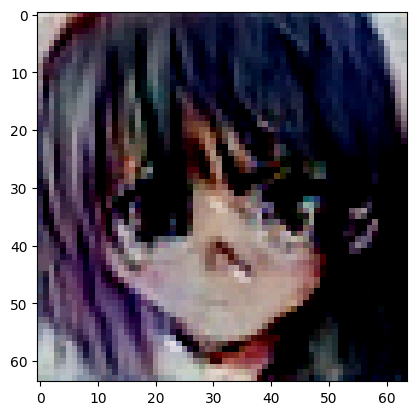

In [11]:
import matplotlib.pyplot as plt
fixed_fake_images = torch.randn(32, 128, 1, 1)
x = fixed_fake_images
x = loaded_gen(x)
x = x.permute(0,2,3,1)
x = x[0]
plt.imshow(x.detach().numpy())